# Q1 | 3.1

# Q2 | 3.2

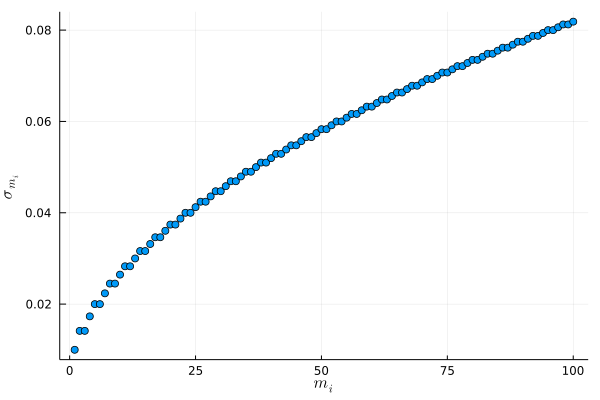

In [191]:
using SparseArrays
using Distributions
using Krylov
using LinearAlgebra
using Plots
using LaTeXStrings

# Taken from Assignment 1
"""Make NxN square matrix and fill it with triplets of a coefficent a.
In a row with index r, the cells [r, r], [r, r-1], [r, r-2] are filled.
Argument a multipes the entire matrix by scalar a.
For example TripletsMatrix(5, 1) produces the sparse matrix
   [1 0 0 0 0;
    1 1 0 0 0;
    1 1 1 0 0;
    0 1 1 1 0;
    0 0 1 1 1]"""
function TripletsMatrix(N::Int, a=1::Number)::SparseMatrixCSC  # a is probably unneccessary (vs hardcoding a=1) except in some odd cases, but including it is trivial.
    #= We are creating a matrix with COO, a coordinate list.
    For some k, row[k] gives row index, col[k] gives col index and val[k] gives the value for that coordinate pair.
    We create the matrices in advance then increment over vector coordiantes with k because it is reportedly faster than appending to matrices. =#
    
    if N < 2 error("N should be at least 2.") end
    
    col = Vector{Int64}(undef, 3*(N-1)) # 3*(N-1) should be the amount of nonzero values <- 3 from the first two rows and 3*(N-2) from the rest.
    row = Vector{Int64}(undef, 3*(N-1))
    val = Vector{Float64}(undef, 3*(N-1))
    k = 1 # This tracks our location in the COO vectors
    for i = 1:N # Row index.
        for j in i-2:i # Column index, for non-zero values. We don't write to any columns higher than i so this doesn't do anything weird in the last row.
            if j > 0 # To handle first two rows.
                col[k] = j
                row[k] = i
                val[k] = a
                k += 1
            end
        end
    end
    sparse(row, col, val) # Takes our vectors and turns them into a sparse matrix
end


function Covariance(m::Vector, G::SparseMatrixCSC, std::Float64)::Matrix
    G = Matrix(G)
    std^2 * inv(transpose(G) * G)
end


function WithinTwoSTD(actual::Vector, est::Vector, std::Vector)::Int
    diff = abs.(actual .- est)
    twosigma = diff[diff .< (2*std)]
    length(twosigma)
end


N = 100 # number of objects

# (A) Randomly assign true masses (0,1] to N objects
mTrue = 1 .- rand(Float64, N) # note subtraction from 1 to convert from [0,1)

# (B) create data kernal G
G = TripletsMatrix(N) 

# (C) Synthesise some data
d_dev = 0.01 # standard dev of data
gaussian = Normal(0, d_dev) # mean 0, std dev d_dev
n = rand(gaussian, N) # 100 gaussian random numbers
d = G * mTrue + n


# (D) Least squares solution for m.
# This lovely function, implemented by Krylov.jl, uses a conjugate gradient method to solve least squares quickly (~ 0.17 ms for this).
# See https://juliasmoothoptimizers.github.io/Krylov.jl/stable/solvers/ls/#Krylov.cgls
# I looked at the BiCG method suggested in Menke, but had some problems with the Julia equivilant.
# I also tried straight up solving the matrix eq:
#   m = inv(transpose(T) * G) * (transpose(G) * d)
# but that was (predicatably) slow.
(mEst, stats) = cgls(G, d)

# (E) Estimate variance of est. model params
# Slow but works for this small N
mCov = Covariance(mEst, G, d_dev) # Using precise data variance because we happened to know it. Normally we'd have to estimate it as in Eq 3.68
mVar = diag(mCov) # Extract vector of variances for mEst from diagonal

# (F) Count number of model params within 2 std. of true value
mStd = mVar .^ 0.5
WithinTwoSTD(mTrue, mEst, mStd)

# (G) Plot model variance as function of index
plot(mStd, seriestype = :scatter, xlabel = L"m_i", ylabel = L"\sigma_{m_i}", legend=false) # std increases